# Supplementary Analysis
> BF15 Numerical Accuracy

> Date.11/4

In [17]:
# Env info
import sys
import torch

print("Python version:", sys.version)
print("Python path:", sys.executable)

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Python path: /usr/local/bin/python
True
NVIDIA A100-PCIE-40GB
12.8


In [18]:
# Import necessary libraries
import torch.nn as nn
import torch.nn.functional as F
import math
import json
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
from bf15_linear import replace_linear_with_bf15, bf15_left_matmul
from bfspmat import replace_linear_with_bf15 as replace_linear_with_bf15_full
from bfspmat import bf15_left_exp_int_matmul
from vit import ImageNetValDataset
from torch.utils.data import DataLoader

### (1) Error Budget Analysis
- Max ULP (Units in the Last Place): The largest difference between the simulated BF15 and FP32 results.
- Mean ULP: The average difference across all layers.
- Histogram of ULPs: To visualize the distribution of errors.

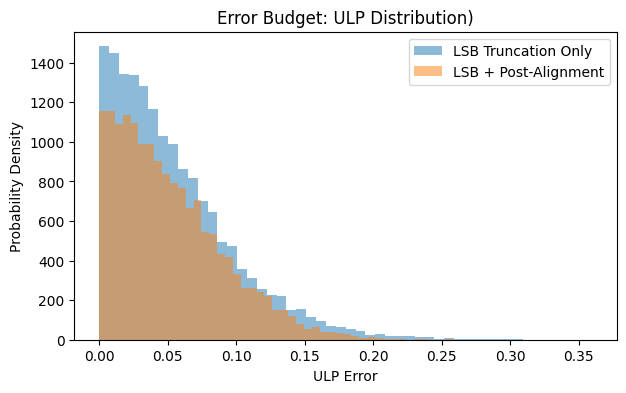

Max ULP (LSB Only): 0.3598213195800781
Mean ULP (LSB Only): 0.05452027916908264
Max ULP (LSB + Post-Alignment): 0.2872352600097656
Mean ULP (LSB + Post-Alignment): 0.051935825496912


In [19]:

# ==========================================
# 1. Error Budget Analysis
# ==========================================
def compute_error_budget(A, B, tile_k=64):
    """
    Compute the error budget for BF15 truncation and post-alignment.
    """
    # FP32 reference
    y_ref = torch.matmul(A.to(torch.float32), B.to(torch.float32))

    # BF15 with LSB truncation only
    y_bf15_lsb = bf15_left_matmul(A, B)

    # BF15 with LSB truncation + post-alignment
    y_bf15_full = bf15_left_exp_int_matmul(A, B, tile_k=tile_k)

    # Compute ULP differences
    ulp_lsb = (y_bf15_lsb - y_ref).abs()
    ulp_full = (y_bf15_full - y_ref).abs()

    return ulp_lsb, ulp_full, y_ref, y_bf15_lsb, y_bf15_full

# Generate random input tensors
device = "cuda" if torch.cuda.is_available() else "cpu"
A = torch.randn(128, 256, dtype=torch.bfloat16, device=device)
B = torch.randn(256, 128, dtype=torch.bfloat16, device=device)

# Compute error budget
ulp_lsb, ulp_full, y_ref, y_bf15_lsb, y_bf15_full = compute_error_budget(A, B)

# Plot histogram of ULPs
density = False # Normalize the histogram
plt.figure(figsize=(7, 4))
plt.hist(ulp_lsb.cpu().numpy().flatten(), bins=50, alpha=0.5, label="LSB Truncation Only", density=density)
plt.hist(ulp_full.cpu().numpy().flatten(), bins=50, alpha=0.5, label="LSB + Post-Alignment", density=density)
plt.xlabel("ULP Error")
plt.ylabel("Probability Density")
plt.legend()
plt.title("Error Budget: ULP Distribution)")
plt.savefig("error_budget_ulp.svg", format="svg")
plt.show()

# Print max and mean ULPs
print(f"Max ULP (LSB Only): {ulp_lsb.max().item()}")
print(f"Mean ULP (LSB Only): {ulp_lsb.mean().item()}")
print(f"Max ULP (LSB + Post-Alignment): {ulp_full.max().item()}")
print(f"Mean ULP (LSB + Post-Alignment): {ulp_full.mean().item()}")

### (2) Ablation Study
- Compare the outputs of the following configurations:\
FP32 baseline: Full precision.\
BF15 with LSB truncation only: Using `bf15_linear.py`.\
BF15 with LSB truncation + post-alignment: Using `bfspmat.py`.
- Measure the accuracy (Top-1, Top-5) and inference time for each configuration.

`wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz`

`tar -xvzf imagenette2-320.tgz`

In [20]:

# ==========================================
# 2. Ablation Study
# ==========================================
from torchvision.models import vit_b_16, ViT_B_16_Weights
from bf15_linear import replace_linear_with_bf15
from bfspmat import replace_linear_with_bf15 as replace_linear_with_bf15_full
from vit import ImageNetValDataset
from torch.utils.data import DataLoader
import os

# Load ViT model
weights = ViT_B_16_Weights.IMAGENET1K_V1
device = "cuda" if torch.cuda.is_available() else "cpu"
model_fp32 = vit_b_16(weights=weights).eval().to(device)

# Clone models for BF15 configurations
model_bf15_lsb = vit_b_16(weights=weights).eval()
model_bf15_full = vit_b_16(weights=weights).eval()

# Replace Linear layers
replace_linear_with_bf15(model_bf15_lsb)  # LSB truncation only
model_bf15_lsb.to(device)  # Ensure the model is on the correct device

replace_linear_with_bf15_full(model_bf15_full)  # LSB + post-alignment
model_bf15_full.to(device)  # Ensure the model is on the correct device

# Load ImageNet validation dataset
imagenet_root = "./imagenette2-320/val"  # Path to the validation dataset

# Generate wnid_map directly from the folder structure
def generate_wnid_map(root_dir):
    classes = sorted(os.listdir(root_dir))
    wnid_map = {cls: idx for idx, cls in enumerate(classes)}
    return wnid_map

wnid_map = generate_wnid_map(imagenet_root)

# Preprocessing and dataset
# Define preprocess
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

subset_size = 50  # Use only 50 samples for evaluation
dataset = ImageNetValDataset(imagenet_root, wnid_map, preprocess)
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset = torch.utils.data.Subset(dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


# Evaluate models
# def evaluate_model(model, dataloader, device):
#     total, correct_top1, correct_top5 = 0, 0, 0
#     with torch.no_grad():
#         for imgs, targets in dataloader:
#             imgs, targets = imgs.to(device), targets.to(device)
#             outputs = model(imgs)
#             total += targets.size(0)
#             _, pred = outputs.topk(5, 1, True, True)
#             correct = pred.eq(targets.view(-1, 1).expand_as(pred))
#             correct_top1 += correct[:, :1].sum().item()
#             correct_top5 += correct[:, :5].sum().item()
#     acc1 = correct_top1 / total * 100
#     acc5 = correct_top5 / total * 100
#     return acc1, acc5
def evaluate_model(model, dataloader, device, micro_batch_size=4):
    total, correct_top1, correct_top5 = 0, 0, 0
    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            batch_size = imgs.size(0)
            for i in range(0, batch_size, micro_batch_size):
                imgs_micro = imgs[i:i+micro_batch_size]
                targets_micro = targets[i:i+micro_batch_size]
                outputs = model(imgs_micro)
                total += targets_micro.size(0)
                _, pred = outputs.topk(5, 1, True, True)
                correct = pred.eq(targets_micro.view(-1, 1).expand_as(pred))
                correct_top1 += correct[:, :1].sum().item()
                correct_top5 += correct[:, :5].sum().item()
    acc1 = correct_top1 / total * 100
    acc5 = correct_top5 / total * 100
    return acc1, acc5


# Evaluate all configurations
print("acc_fp32 = evaluate_model(model_fp32, dataloader, device)\n")
acc_fp32 = evaluate_model(model_fp32, dataloader, device)
print(f"FP32 Accuracy: Top-1 {acc_fp32[0]:.2f}%, Top-5 {acc_fp32[1]:.2f}%")
print("-" * 100)


print("acc_bf15_lsb = evaluate_model(model_bf15_lsb, dataloader, device)\n")
acc_bf15_lsb = evaluate_model(model_bf15_lsb, dataloader, device)
print(f"BF15 (LSB Only) Accuracy: Top-1 {acc_bf15_lsb[0]:.2f}%, Top-5 {acc_bf15_lsb[1]:.2f}%")
print("-" * 100)


print("acc_bf15_full = evaluate_model(model_bf15_full, dataloader, device)\n")
acc_bf15_full = evaluate_model(model_bf15_full, dataloader, device)
print(f"BF15 (LSB + Post-Alignment) Accuracy: Top-1 {acc_bf15_full[0]:.2f}%, Top-5 {acc_bf15_full[1]:.2f}%")
print("-" * 100)

acc_fp32 = evaluate_model(model_fp32, dataloader, device)

FP32 Accuracy: Top-1 16.00%, Top-5 16.00%
----------------------------------------------------------------------------------------------------
acc_bf15_lsb = evaluate_model(model_bf15_lsb, dataloader, device)

BF15 (LSB Only) Accuracy: Top-1 16.00%, Top-5 16.00%
----------------------------------------------------------------------------------------------------
acc_bf15_full = evaluate_model(model_bf15_full, dataloader, device)



OutOfMemoryError: CUDA out of memory. Tried to allocate 6.93 GiB. GPU 0 has a total capacity of 39.49 GiB of which 4.66 GiB is free. Process 1896216 has 34.82 GiB memory in use. Of the allocated memory 34.05 GiB is allocated by PyTorch, and 286.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)